# Video Pipeline Demonstrating Applying Labels Based on Timestamps or Frame Numbers

In this example, we will go through the creation of a pipeline using the [readers.video](../../../operations/nvidia.dali.fn.readers.video.html) operator to read videos along with their labels. We will apply labels to the video based on frame numbers as input, and read timestamp and frame number labels along with decoded video frames.

For more information on the `readers.video` parameters, please look at the documentation.

First let's import the libraries.

In [1]:
import os
import numpy as np
import tempfile
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

try:
    from PIL import Image
    has_PIL = True
except ImportError:
    has_PIL = False

Then we define that in each iteration of the pipeline we want 4 batches and each batch has sequence length of 1 frame. We want to run 10 iterations for illustrative purpose.

In [2]:
BATCH_SIZE=4
COUNT=1
ITER=10
frame_num_based_labels=True

The video we have used in this example is a 10 seconds long, 25fps, 512x512 resolution video with timestamp burned into the frame itself in the top half of the video and frame number in the bottom half. The burned text in the decoded frame can be easily used to verify that we are indeed returned the correct frame number and timestamp labels.

**Note**: `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [3]:
dali_extra_path = os.environ['DALI_EXTRA_PATH']
file_list_txt = dali_extra_path + "/db/video/test_label.mp4 0 0 100\n"
file_list_txt += dali_extra_path + "/db/video/test_label.mp4 1 100 200\n"
file_list_txt += dali_extra_path + "/db/video/test_label.mp4 2 200 250\n"
tf = tempfile.NamedTemporaryFile()
tf.write(str.encode(file_list_txt))
tf.flush()

## Defining the Pipeline
We can then define a minimal Pipeline that will output directly the [readers.video](../../../operations/nvidia.dali.fn.readers.video.html) outputs.

Notice that we set `file_list_frame_num=True`, this means that the labels we provided above using `file_list` will be interpreted as frame numbers.
`test_label.mp4 0 0 100` is interpreted as applying label `0` from frame number `0` to `100`(excluding).

If however you wished to apply labels using timestamp, simply set `file_list_frame_num=False` (default behaviour), and provide timestamps you wish to apply the label to. For example, if you wished to apply a label `1` to frames from `3` seconds to `8.5` seconds: `test_label.mp4 1 3 8.5`

In this example we have set both `enable_frame_num` and `enable_timestamps` to `True` for illustrative purpose. You can enable or disable either of them depending on your particular use case.

In [4]:
@pipeline_def
def video_pipe(file_list):
    video, label, start_frame_num, timestamps = \
        fn.readers.video(device="gpu", file_list=file_list, sequence_length=COUNT,
                         shard_id=0, num_shards=1, random_shuffle=True, initial_fill=10,
                         image_type=types.RGB, dtype=types.FLOAT, file_list_frame_num=frame_num_based_labels,
                         enable_frame_num=True, enable_timestamps=True)
    return video, label, start_frame_num, timestamps

## Visualizing the Results
We will use matplotlib to display the frames we obtained and the associated labels.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

[/home/jlisiecki/Dali/dali/dali/operators/reader/loader/video_loader.h:179] ``file_list_include_preceding_frame`` uses the default value False. In future releases, the default value will be changed to True.


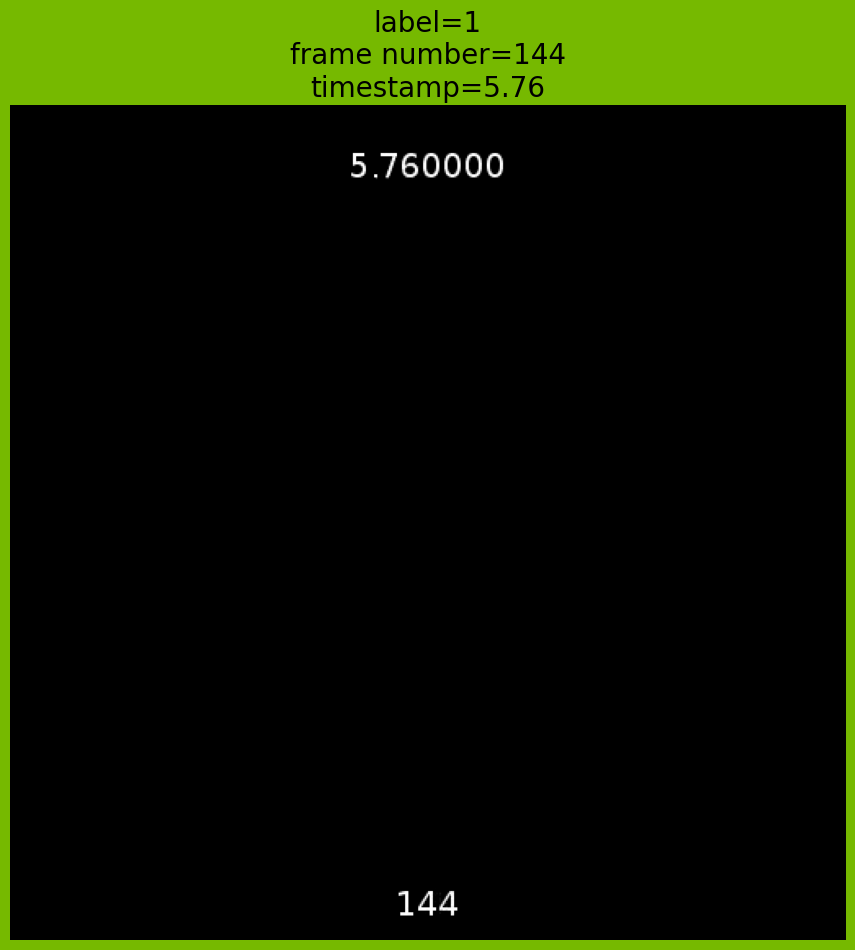

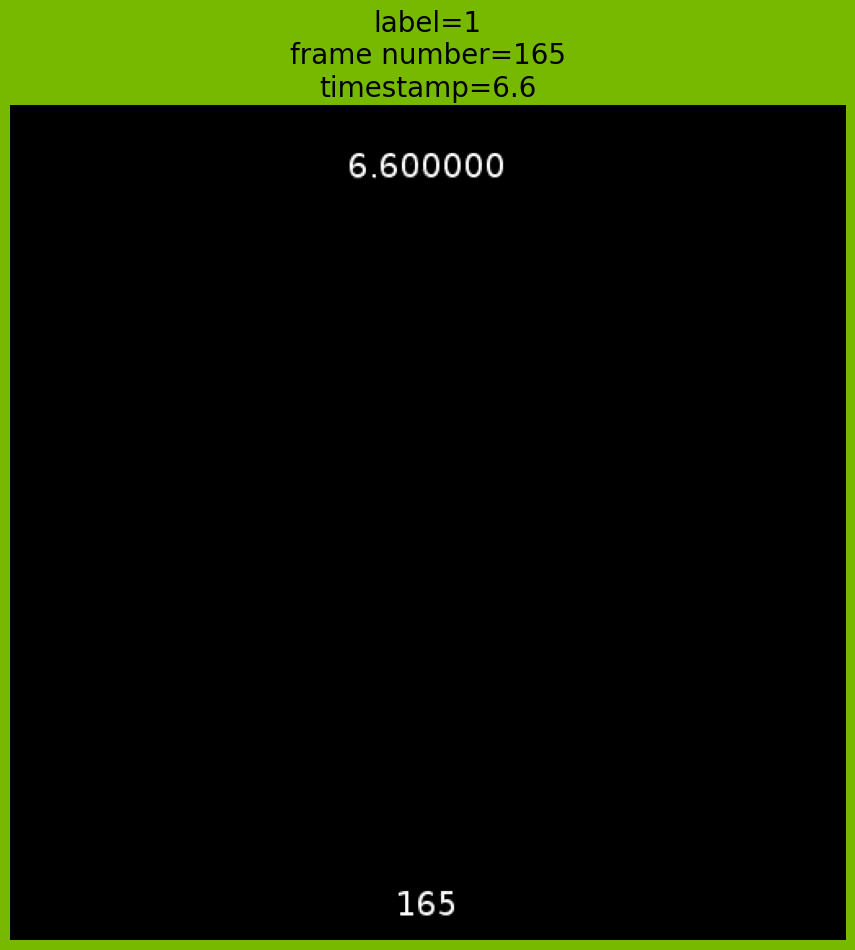

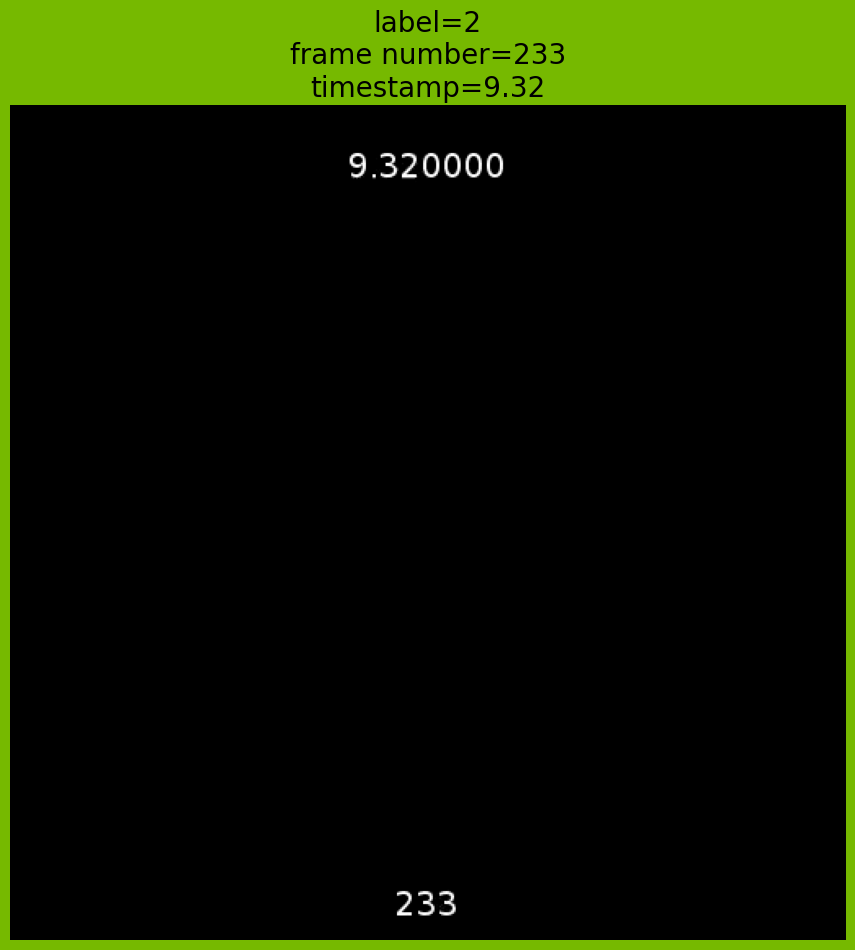

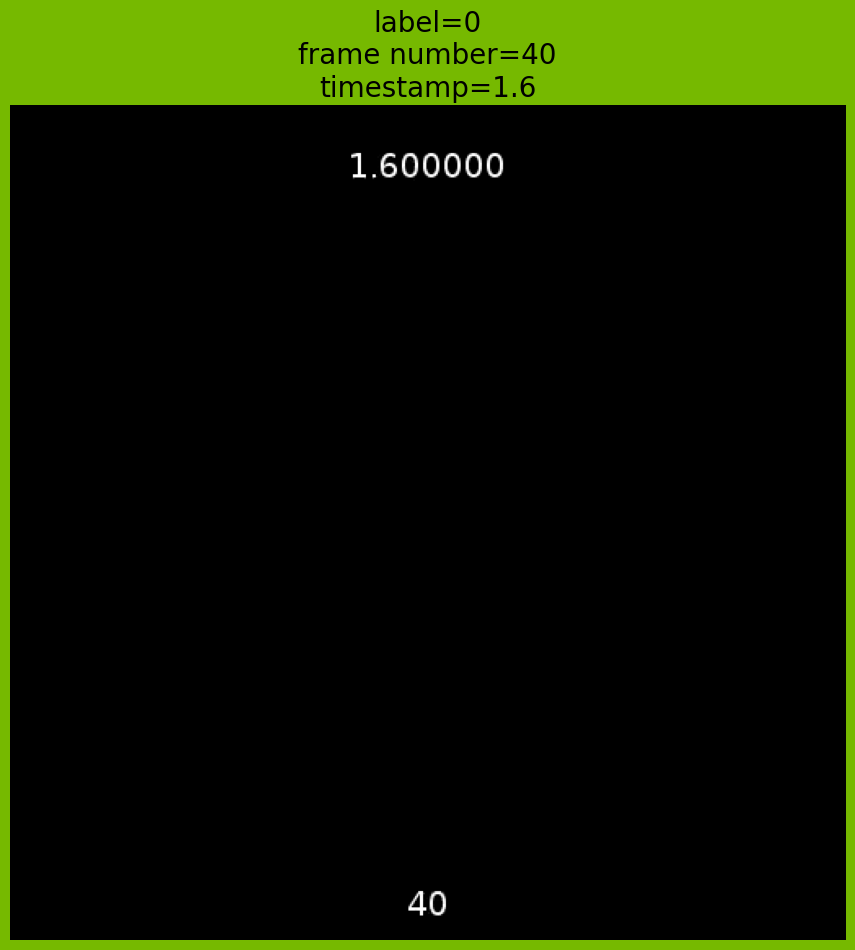

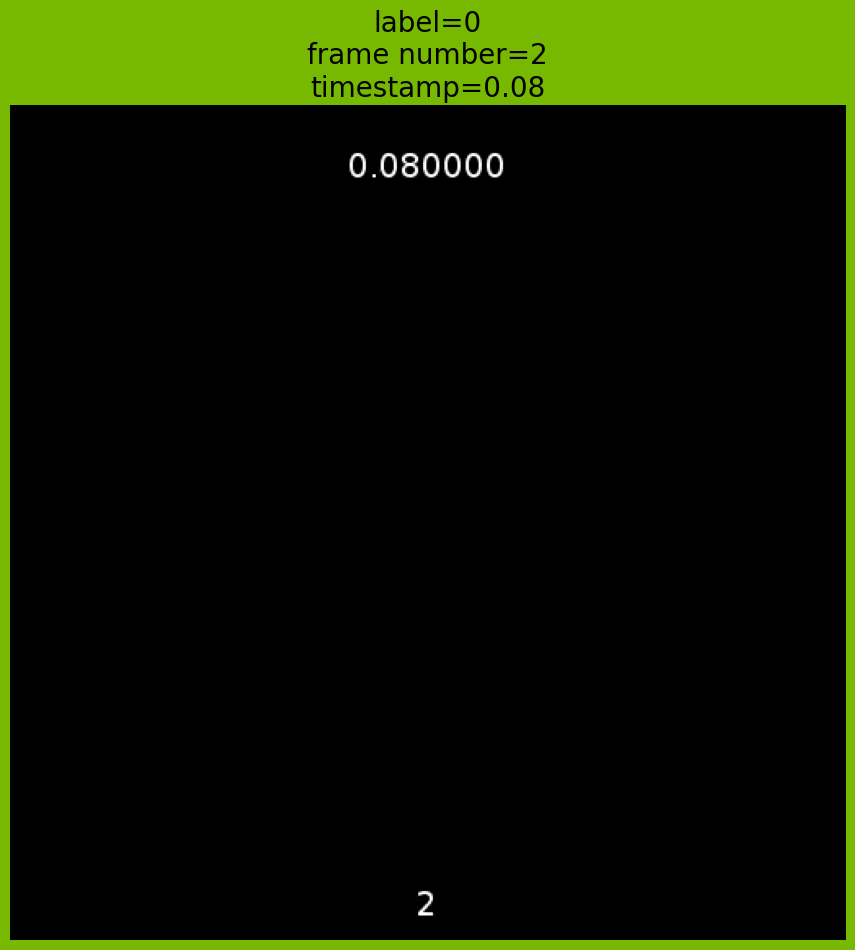

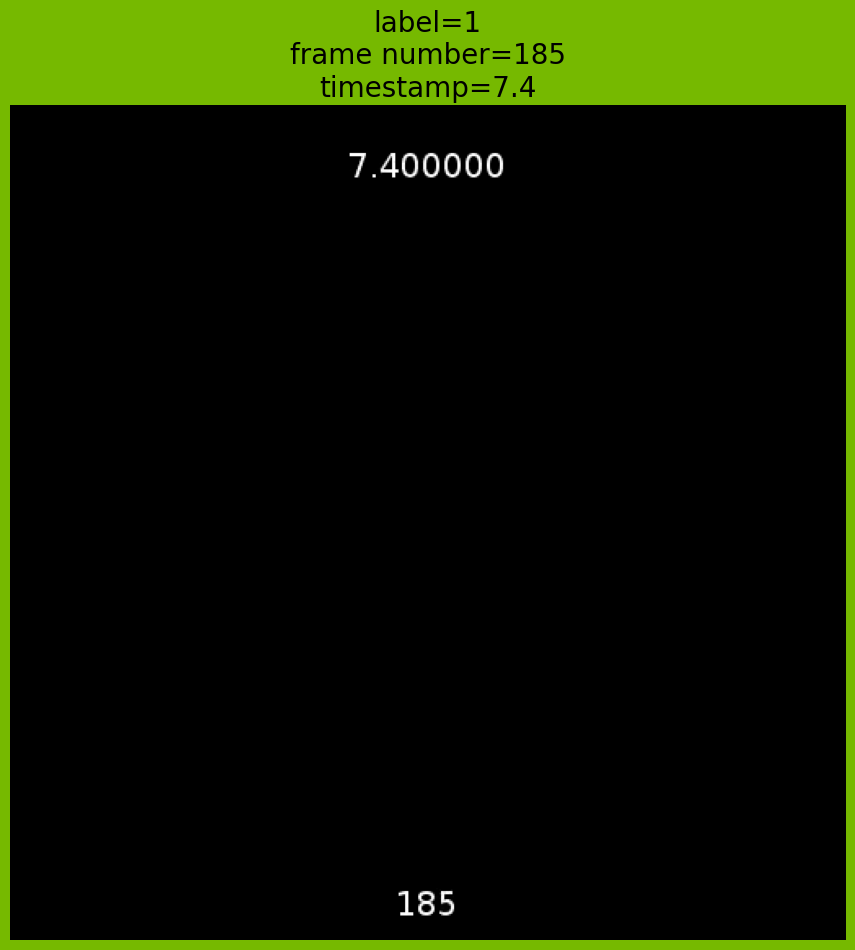

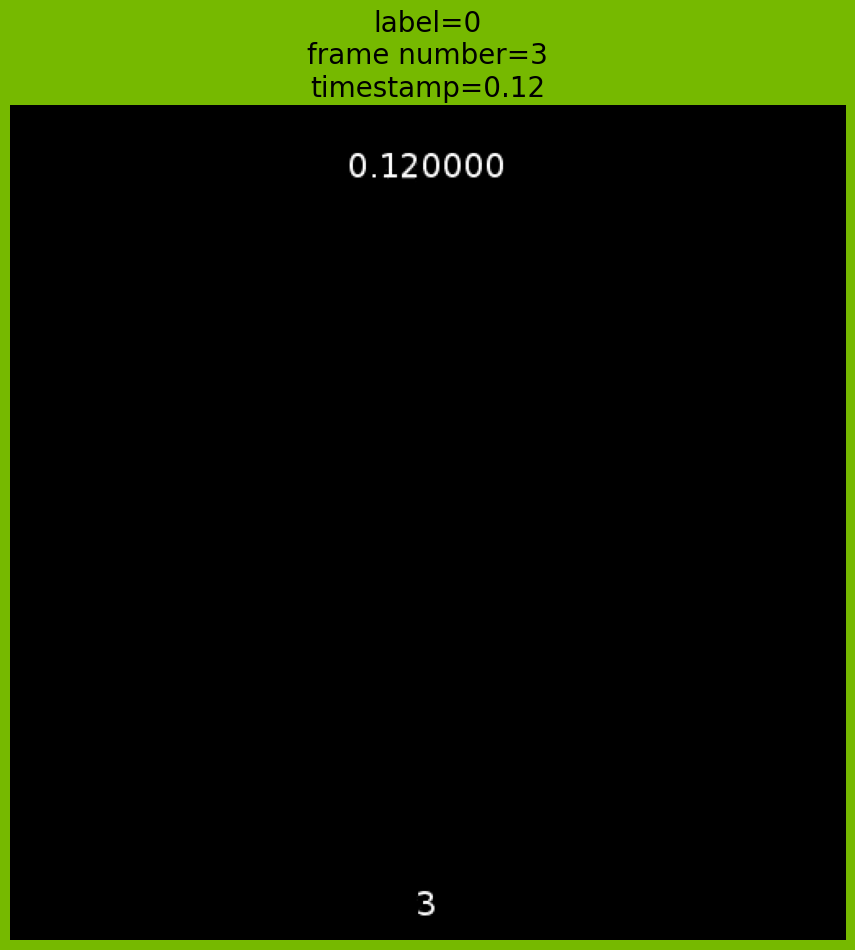

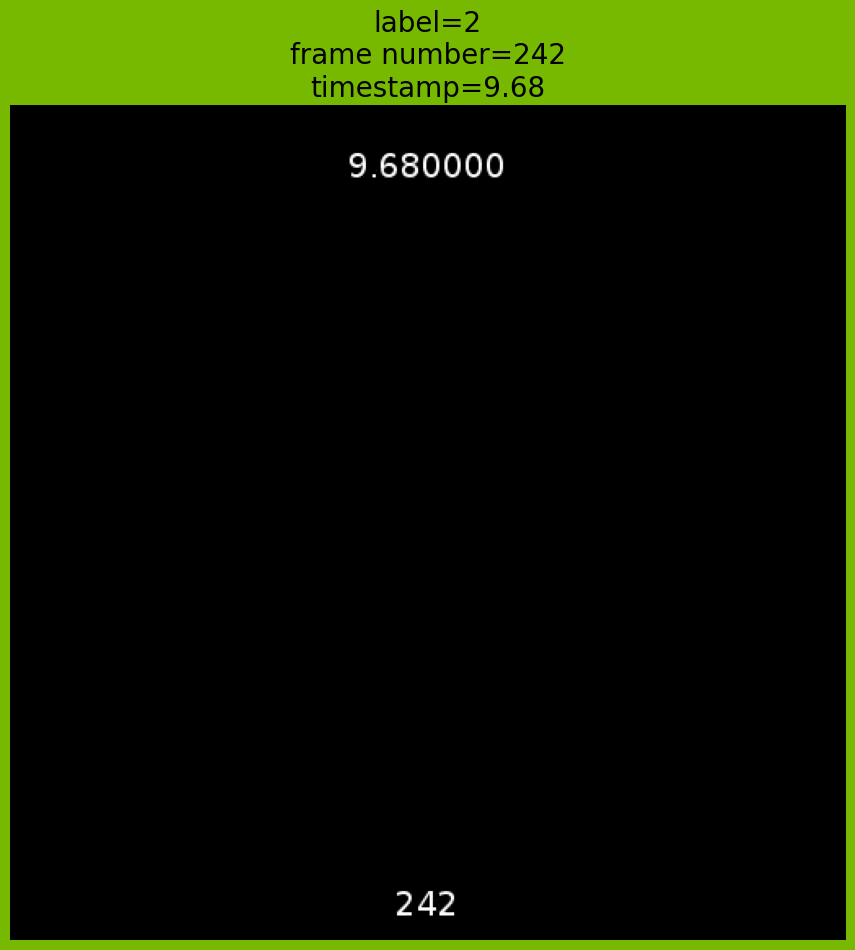

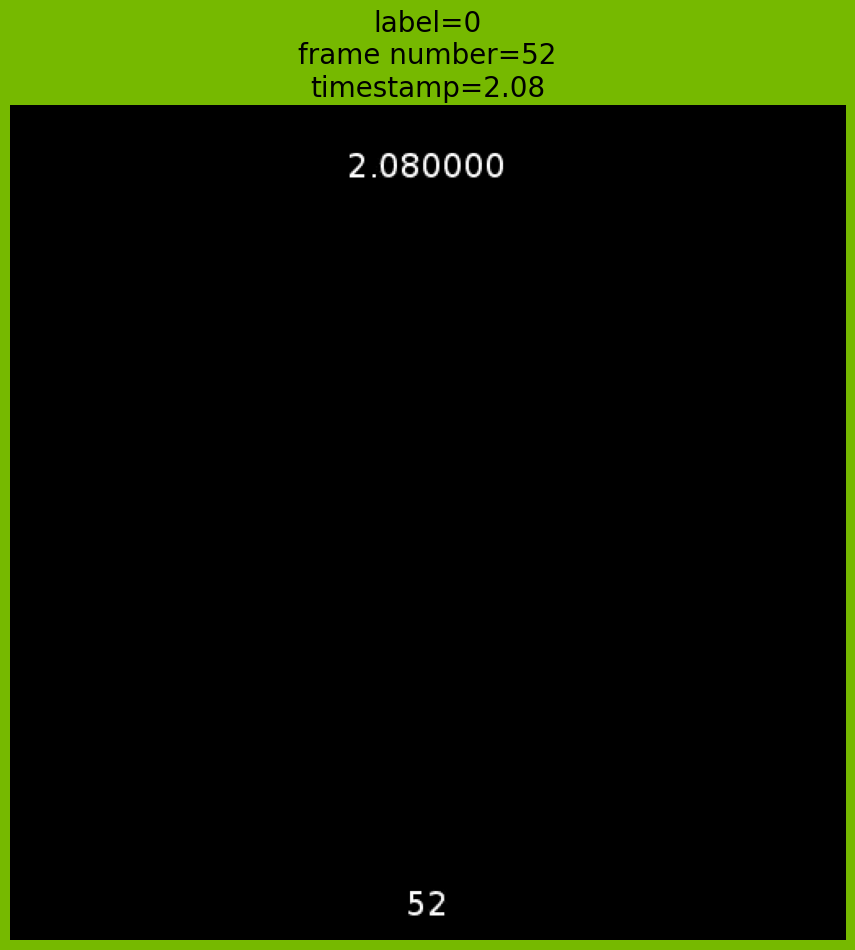

In [6]:
pipe = video_pipe(batch_size=BATCH_SIZE, num_threads=2, device_id=0, file_list=tf.name)
pipe.build()
gs = gridspec.GridSpec(ITER, 1)

for i in range(ITER):
    sequences_out, label, start_frame_num, timestamps = pipe.run()
    sequences_out = sequences_out.as_cpu().as_array()
    label  = label.as_cpu().as_array()
    start_frame_num = start_frame_num.as_cpu().as_array()
    timestamps = timestamps.as_cpu().as_array()
    batch_sequences = sequences_out[0]
    sample_frame = batch_sequences[0]
    if has_PIL:
        im = Image.fromarray(sample_frame.astype('uint8'))
        fig = plt.figure(figsize = (16,128), facecolor="#76b900")
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title("label=" + str(label[0][0]) + '\n'
                  "frame number=" + str(start_frame_num[0][0]) + '\n'
                  "timestamp=" + str(round(timestamps[0][0], 2)), fontsize=20)
        plt.imshow(im)
plt.close()
tf.close()